In [20]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df = pd.read_csv("bbc_data.csv")
df_fox = pd.read_csv("fox_news_data.csv")
df['category_id'] = df.category.factorize()[0]
df_fox['category_id'] = df_fox.category.factorize()[0]
category_id_df = df[['category', 'category_id']].drop_duplicates().sort_values('category_id')
category_id_df_fox = df_fox[['category', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
category_to_id_fox = dict(category_id_df_fox.values)
id_to_category = dict(category_id_df[['category_id', 'category']].values)
id_to_category_fox = dict(category_id_df_fox[['category_id', 'category']].values)

In [3]:
# df.groupby('category').filename.count().plot.bar(ylim=0)

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(df.content).toarray()
labels = df.category_id
features.shape


(2225, 14316)

In [7]:
# from sklearn.feature_selection import chi2

# N = 3
# for category, category_id in sorted(category_to_id.items()):
#     features_chi2 = chi2(features, labels == category_id)
#     indices = np.argsort(features_chi2[0])
#     feature_names = np.array(tfidf.get_feature_names())[indices]
#     unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
#     bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
#     print("# '{}':".format(category))
#     print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:])))
#     print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:])))

Text(0.5,1,'tf-idf feature vector for each article, projected on 2 dimensions.')

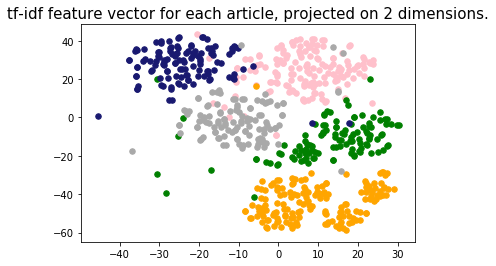

In [4]:
from sklearn.manifold import TSNE

# Sampling a subset of our dataset because t-SNE is computationally expensive
SAMPLE_SIZE = int(len(features) * 0.3)
np.random.seed(0)
indices = np.random.choice(range(len(features)), size=SAMPLE_SIZE, replace=False)
projected_features = TSNE(n_components=2, random_state=0).fit_transform(features[indices])
colors = ['pink', 'green', 'midnightblue', 'orange', 'darkgrey']
for category, category_id in sorted(category_to_id.items()):
    points = projected_features[(labels[indices] == category_id).values]
    plt.scatter(points[:, 0], points[:, 1], s=30, c=colors[category_id], label=category)
plt.title("tf-idf feature vector for each article, projected on 2 dimensions.",
          fontdict=dict(fontsize=15))


In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.svm import LinearSVC  

from sklearn.model_selection import cross_val_score


models = [
    MultinomialNB(),
    LogisticRegression(random_state=0),
    KNeighborsClassifier(n_neighbors=5),
    LinearSVC(multi_class='ovr')     
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])


cv_df.groupby('model_name').accuracy.mean()

model_name
KNeighborsClassifier    0.955052
LinearSVC               0.973490
LogisticRegression      0.966765
MultinomialNB           0.960461
Name: accuracy, dtype: float64

Text(0.5,15,'Predicted')

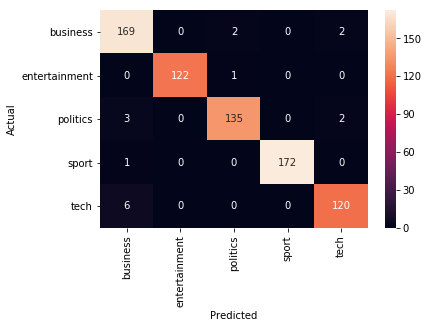

In [8]:
from sklearn.model_selection import train_test_split

model = LogisticRegression(random_state=0)

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred_proba = model.predict_proba(X_test)
y_pred = model.predict(X_test)

from sklearn import metrics
acc =metrics.accuracy_score(y_test, y_pred)
print("Without K-fold Accuracy for Logistic Regression")
print(acc)

from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.category.values, yticklabels=category_id_df.category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')

Accuracy for Logistic REgression
0.9768707482993197


Without K-fold Accuracy for Multinomial NB
0.9714285714285714


Text(0.5,15,'Predicted')

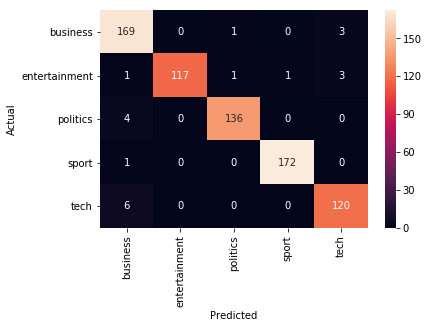

In [17]:
from sklearn.model_selection import train_test_split

model = MultinomialNB()

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred_proba = model.predict_proba(X_test)
y_pred = model.predict(X_test)


from sklearn import metrics
acc =metrics.accuracy_score(y_test, y_pred)
print("Without K-fold Accuracy for Multinomial NB")
print(acc)


from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.category.values, yticklabels=category_id_df.category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')

Without K-fold Accuracy for KNeighborsClassifier
0.964625850340136


Text(0.5,15,'Predicted')

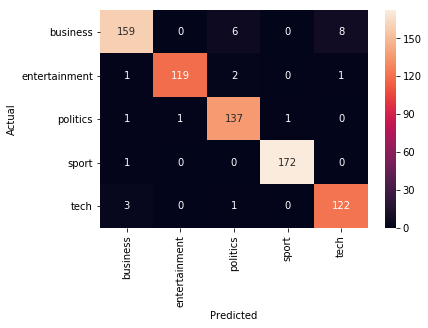

In [15]:
from sklearn.model_selection import train_test_split

model = KNeighborsClassifier(n_neighbors=5)

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred_proba = model.predict_proba(X_test)
y_pred = model.predict(X_test)


from sklearn import metrics
acc =metrics.accuracy_score(y_test, y_pred)
print("Without K-fold Accuracy for KNeighborsClassifier")
print(acc)


from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.category.values, yticklabels=category_id_df.category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')

Without K-fold Accuracy for LinearSVC
0.9836734693877551


Text(0.5,15,'Predicted')

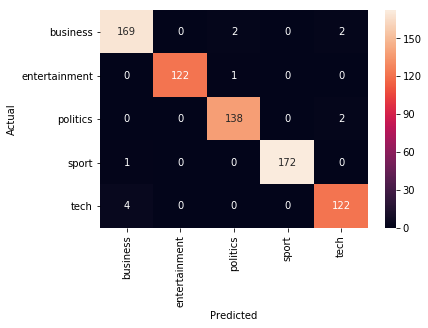

In [16]:
from sklearn.model_selection import train_test_split

model = LinearSVC(multi_class='ovr')

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

from sklearn import metrics
acc =metrics.accuracy_score(y_test, y_pred)
print("Without K-fold Accuracy for LinearSVC")
print(acc)


from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.category.values, yticklabels=category_id_df.category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')

In [ ]:
from sklearn.model_selection import train_test_split

model = LinearSVC(multi_class='ovr')

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

from sklearn import metrics
acc =metrics.accuracy_score(y_test, y_pred)
print("Without K-fold Accuracy for LinearSVC")
print(acc)


from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.category.values, yticklabels=category_id_df.category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')